In [1]:
import numpy as np
import matplotlib.pyplot as plt

заданные в варианте функции и метод прогонки

In [2]:
def f(x, y, t):
    return -x*y*np.sin(t)
def phi1(y, t):
    return 0
def phi2(y, t):
    return y*np.cos(t)
def phi3(x, t):
    return 0
def phi4(x, t):
    return x*np.cos(t)
def psi(x, y):
    return x*y
def solution(x, y, t):
    return x*y*np.cos(t)

In [3]:
l = 1
N = 10
K = 100
Tk = 2
h = l/N
tau = Tk/K
x = np.linspace(0, l, N)
y = np.linspace(0, l, N)
t = np.linspace(0, Tk, K)
X, Y, T = np.meshgrid(x, y, t)

In [4]:
def tma(a, b, c, d):
    n = len(a)
    p, q = [], []
    p.append(-c[0] / b[0])
    q.append(d[0] / b[0])
    for i in range(1, n):
        p.append(-c[i] / (b[i] + a[i] * p[i - 1]))
        q.append((d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1]))
    x = [0 for _ in range(n)]
    x[n - 1] = q[n - 1]
    for i in range(n-2, -1, -1):
        x[i] = p[i] * x[i+1] + q[i]
    return x

аналитическое решение

In [5]:
def analitic_solve(N, l, K, T):
    u = np.zeros((N, N, K))
    for i in range(N):
        for j in range(N):
            for k in range(K):
                u[i][j][k] = solution(i*h, j*h, k*tau)
    return u

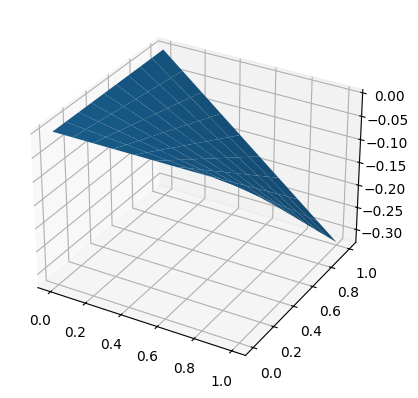

In [6]:
analitic = analitic_solve(N, l, K, Tk)
x_plt, y_plt = np.meshgrid(x, y)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(x_plt, y_plt, np.array(analitic[:, :, -1]))
plt.show()

метод переменных направлений

In [7]:
def MPN(lbx, ubx, nx, lby, uby, ny, T, K):
    hx = (ubx - lbx)/nx
    x = np.arange(lbx, ubx + hx, hx)
    hy = (uby - lby)/ny
    y = np.arange(lby, uby + hy, hy)
    tau = T/K
    t = np.arange(0, T + tau, tau)

    UU = np.zeros((len(x),len(y),len(t)))
    for i in range(len(x)):
        for j in range(len(y)):
            UU[i,j,0] = psi(x[i], y[j]) 

    for k in range(1,len(t)):
        U1 = np.zeros((len(x),len(y)))
        t2 = t[k] - tau/2
        #первый дробный шаг
        L = np.zeros((len(x),len(y)))
        L = UU[:,:,k-1]
        for j in range(len(y)-1):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))
            bb[0] = hx
            bb[-1] = hx
            cc[0] = 0
            aa[-1] = 0
            dd[0] = phi1(y[j],t2)*hx
            dd[-1] = phi2(y[j],t2)*hx
            for i in range(1, len(x)-1):
                aa[i] = 1
                bb[i] = hx**2 - 2*(hx**2)/tau - 2
                cc[i] = 1
                dd[i] = -2*(hx**2)*L[i,j]/tau - 1*(hx**2)*(L[i,j+1] - 2*L[i,j] + L[i,j-1])/(hy**2) - (hx**2)*f(x[i],y[j],t2)
            xx = tma(aa, bb, cc, dd)
            for i in range(len(x)):
                U1[i,j] = xx[i]
                U1[i,0] = (phi3(x[i],t2))
                U1[i,-1] = (phi4(x[i],t2))
        for j in range(len(y)):
            U1[0,j] = (phi1(y[j],t2))
            U1[-1,j] = (phi2(y[j],t2))          
        #второй дробный шаг
        U2 = np.zeros((len(x),len(y)))
        
        for i in range(len(x)-1):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))
            bb[0] = hy
            bb[-1] = hy
            cc[0] = 0
            aa[-1] = 0
            dd[0] = phi3(x[i],t[k])*hy
            dd[-1] = phi4(x[i],t[k])*hy           
            for j in range(1, len(y)-1):
                aa[j] = 1
                bb[j] = hy**2 - 2*(hy**2)/tau - 2
                cc[j] = 1
                dd[j] = -2*(hy**2)*U1[i,j]/tau - 1*(hy**2)*(U1[i+1,j] - 2*U1[i,j] + U1[i-1,j])/(hx**2) - (hy**2)*f(x[i],y[j],t[k])
            xx = tma(aa, bb, cc, dd)            
            for j in range(len(y)):
                U2[i,j] = xx[j]
                U2[0,j] = (phi1(y[j],t[k]))
                U2[-1,j] = (phi2(y[j],t[k]))
        for i in range(len(x)):
            U2[i,0] = (phi3(x[i],t[k]))
            U2[i,-1] = (phi4(x[i],t[k]))            
        #print(U2)
        for i in range(len(x)):
            for j in range(len(y)):
                UU[i,j,k] = U2[i,j]
        
    return UU

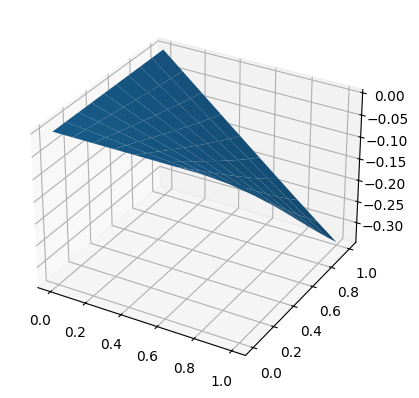

In [8]:
pn = MPN(0, 1, N, 0, 1, N, Tk, K)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(x_plt, y_plt,np.array(pn[:10, :10, -1]))
plt.show()

метод дробных шагов

In [10]:
def MDSH(lbx, ubx, nx, lby, uby, ny, T, K):
    hx = (ubx - lbx)/nx
    x = np.arange(lbx, ubx + hx, hx)
    hy = (uby - lby)/ny
    y = np.arange(lby, uby + hy, hy)
    tau = T/K
    t = np.arange(0, T + tau, tau)

    UU = np.zeros((len(x),len(y),len(t)))
    for i in range(len(x)):
        for j in range(len(y)):
            UU[i,j,0] = psi(x[i], y[j]) 
    
    for k in range(1,len(t)):
        U1 = np.zeros((len(x),len(y)))
        t2 = t[k] - tau/2
        #первый дробный шаг
        L = np.zeros((len(x),len(y)))
        L = UU[:,:,k-1]
        for j in range(len(y)-1):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))
            bb[0] = hx
            bb[-1] = hx
            cc[0] = 0
            aa[-1] = 0
            dd[0] = phi1(y[j],t2)*hx
            dd[-1] = phi2(y[j],t2)*hx
            for i in range(1, len(x)-1):
                aa[i] = 1 
                bb[i] =  - (hx**2)/tau - 2
                cc[i] = 1 
                dd[i] = -(hx**2)*L[i,j]/tau - (hx**2)*f(x[i],y[j],t2)/2
            xx = tma(aa, bb, cc, dd)
            for i in range(len(x)):
                U1[i,j] = xx[i]
                U1[i,0] = (phi3(x[i],t2))
                U1[i,-1] = (phi4(x[i],t2))
        for j in range(len(y)):
            U1[0,j] = (phi1(y[j],t2))
            U1[-1,j] = (phi2(y[j],t2))          
        #второй дробный шаг
        U2 = np.zeros((len(x),len(y)))
        
        for i in range(len(x)-1):
            aa = np.zeros(len(x))
            bb = np.zeros(len(x))
            cc = np.zeros(len(x))
            dd = np.zeros(len(x))
            bb[0] = hy
            bb[-1] = hy
            cc[0] = 0
            aa[-1] = 0
            dd[0] = phi3(x[i],t[k])*hy
            dd[-1] = phi4(x[i],t[k])*hy           
            for j in range(1, len(y)-1):
                aa[j] = 1 
                bb[j] = - (hy**2)/tau - 2
                cc[j] = 1 
                dd[j] = -(hy**2)*U1[i,j]/tau - (hy**2)*f(x[i],y[j],t[k])/2
            xx = tma(aa, bb, cc, dd)            
            for j in range(len(y)):
                U2[i,j] = xx[j]
                U2[0,j] = (phi1(y[j],t[k]))
                U2[-1,j] = (phi2(y[j],t[k]))
        for i in range(len(x)):
            U2[i,0] = (phi3(x[i],t[k]))
            U2[i,-1] = (phi4(x[i],t[k]))           
        #print(U2)
        for i in range(len(x)):
            for j in range(len(y)):
                UU[i,j,k] = U2[i,j]
        
    
    return UU

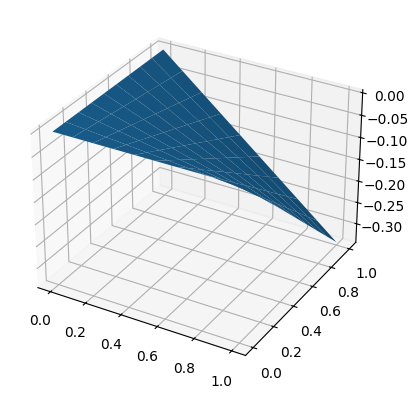

In [11]:
fs = MDSH(0, 1, N, 0, 1, N, Tk, K)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(x_plt, y_plt,np.array(fs[:10, :10, -1]))
plt.show()

погрешности для каждого метода в различные моменты времени

In [12]:
def pogr(res, u, t):
    return np.sqrt(sum([sum([(u[i][j][t]-res[i][j][t])**2 for j in range(len(x))]) for i in range(len(y))]))

In [13]:
pogr(pn, analitic, 4)

0.08848371356825555

In [14]:
pogr(fs, analitic, 4)

0.00042177518087825605

In [15]:
pogr(pn, analitic, 58)

0.04905504747953388

In [16]:
pogr(fs, analitic, 58)

0.00023965383207673926

In [17]:
pogr(pn, analitic, 94)

0.02901032197841562

In [18]:
pogr(fs, analitic, 94)

0.00013742875416250075